In [15]:
import math
from dataclasses import dataclass
from typing import Tuple, Callable
import numpy as np, pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Optimizer
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from itertools import product
import random
import time
from itertools import combinations
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from collections import defaultdict

## Wine
- 178 samples, 13 numeric features
- Chemical analysis of wine (alcohol, malic acid, ash, magnesium, flavanoids, etc.)
- 3 classes (wine cultivars from different Italian regions)
- Medium complexity. Features are continuous and somewhat correlated
- Standardization is important due to differing feature scales

(178, 13) (178,)


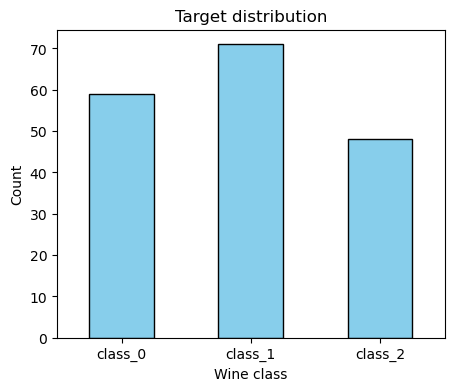

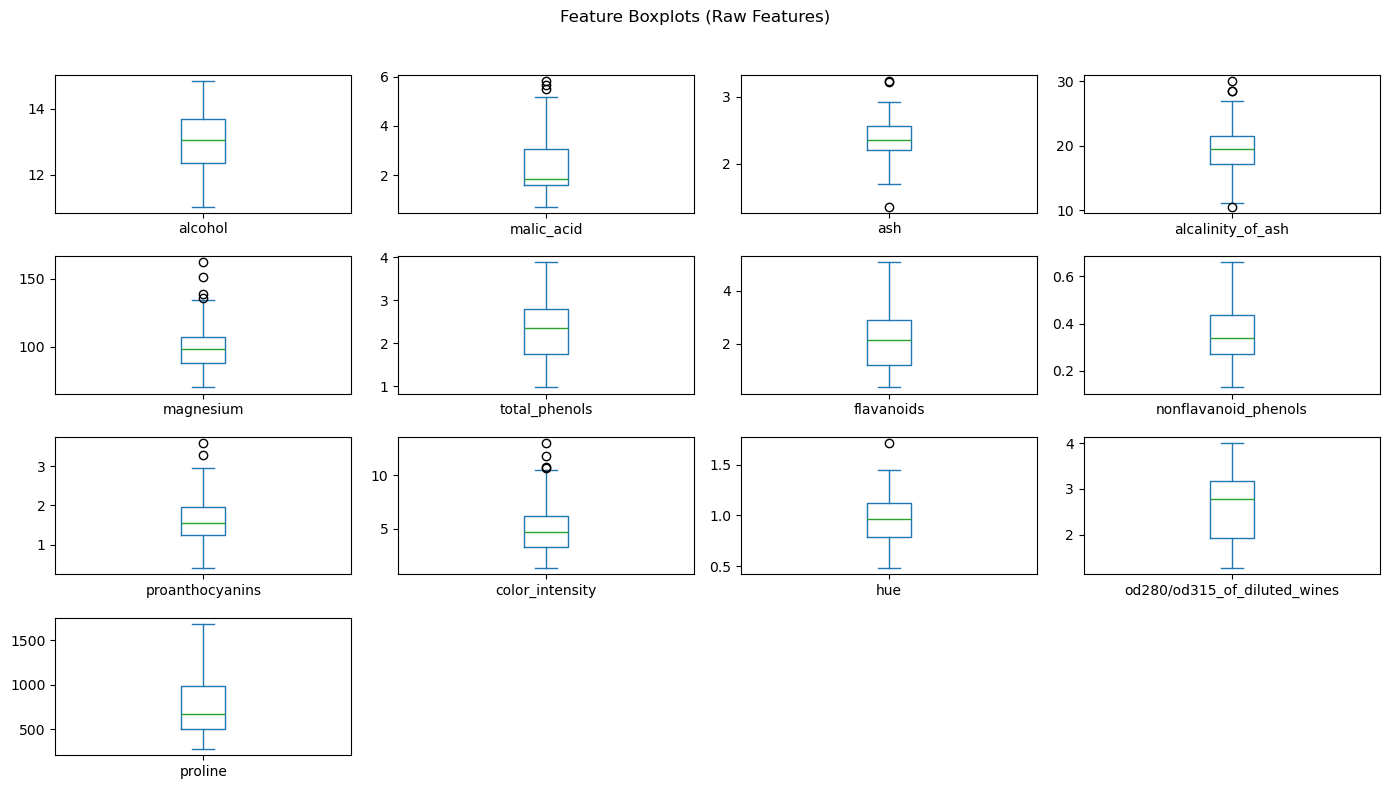

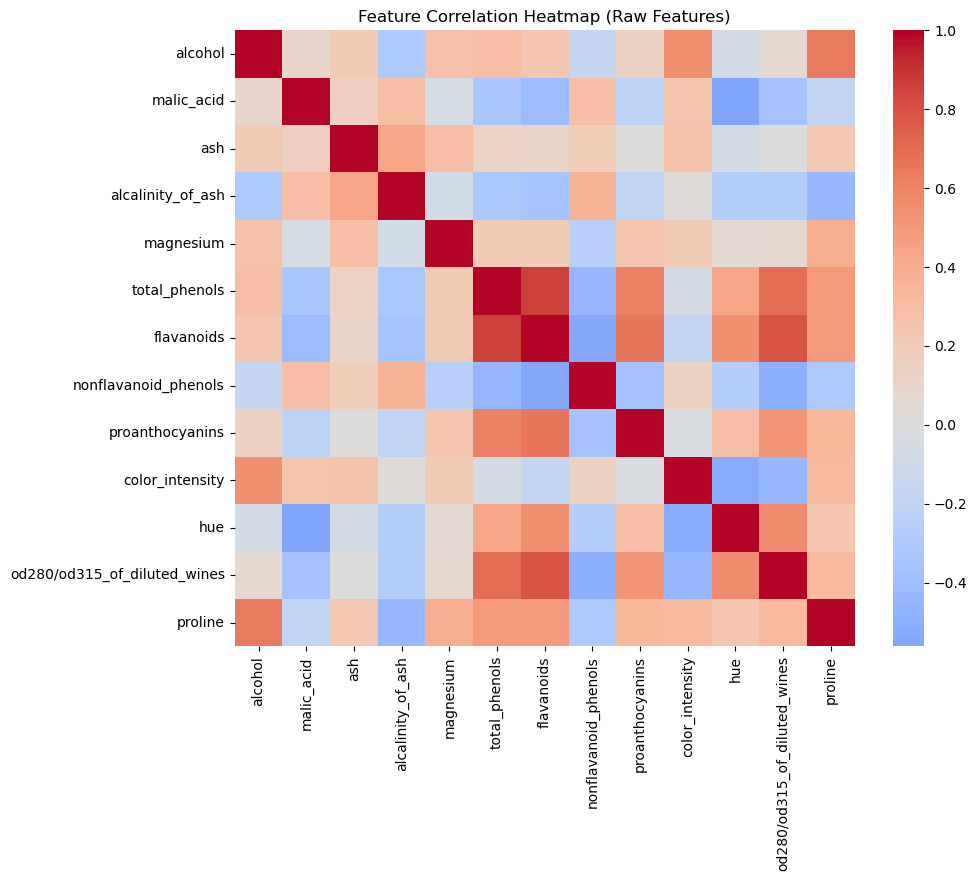

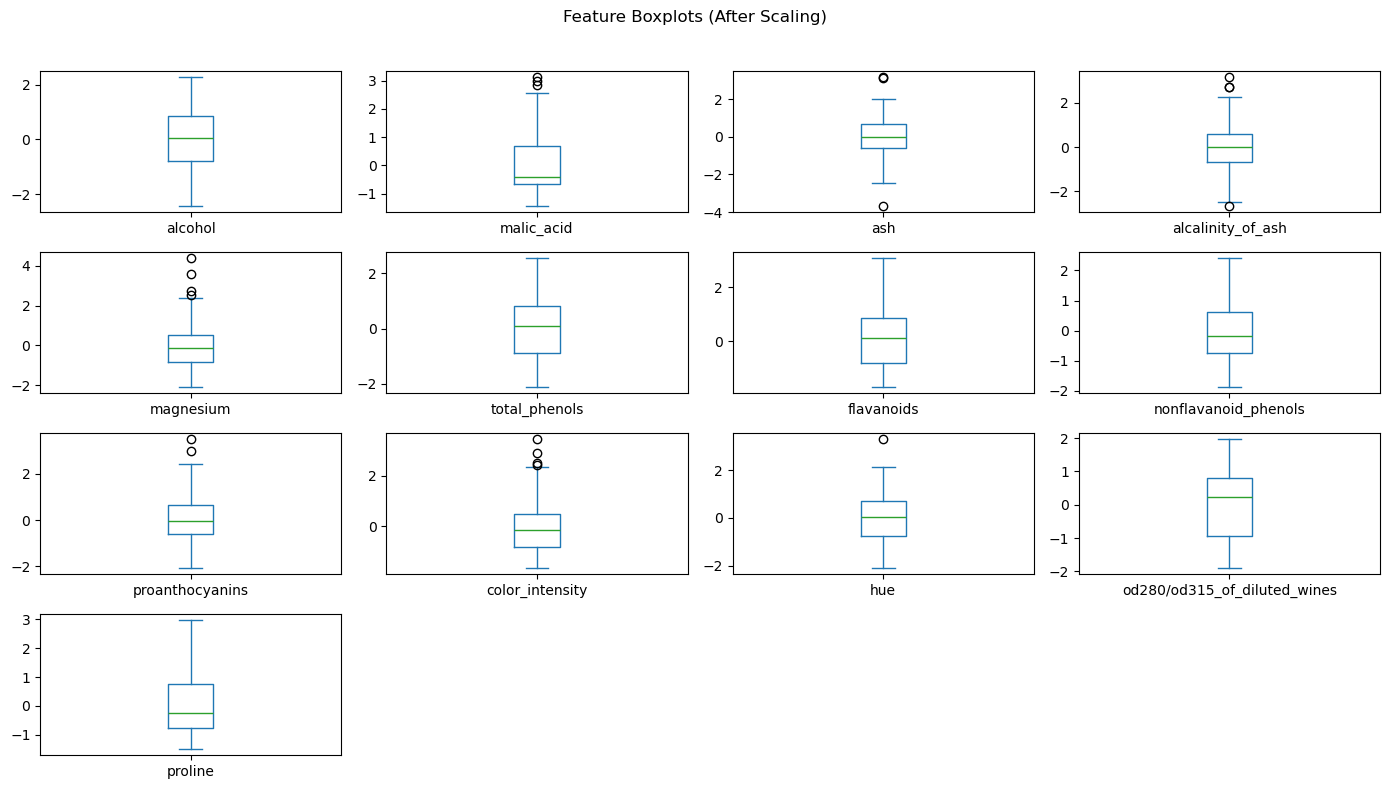

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler

wine = load_wine()
X = pd.DataFrame(wine.data, columns=wine.feature_names)
y = pd.Series(wine.target, name="target")

print(X.shape, y.shape)  

plt.figure(figsize=(5,4))
y.value_counts().sort_index().plot(kind="bar", color="skyblue", edgecolor="k")
plt.xticks([0,1,2], wine.target_names, rotation=0)
plt.xlabel("Wine class")
plt.ylabel("Count")
plt.title("Target distribution")
plt.show()

X.plot(kind="box", subplots=True, layout=(4,4), figsize=(14,8), sharey=False)
plt.suptitle("Feature Boxplots (Raw Features)")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(X.corr(), cmap="coolwarm", center=0, annot=False)
plt.title("Feature Correlation Heatmap (Raw Features)")
plt.show()

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_scaled.plot(kind="box", subplots=True, layout=(4,4), figsize=(14,8), sharey=False)
plt.suptitle("Feature Boxplots (After Scaling)")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [18]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [19]:
wine = load_wine()
X = wine.data
y = wine.target
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val   = torch.tensor(X_val, dtype=torch.float32)
y_val   = torch.tensor(y_val, dtype=torch.long)
X_test  = torch.tensor(X_test, dtype=torch.float32)
y_test  = torch.tensor(y_test, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train, y_train),
                          batch_size=len(X_train), shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val, y_val), batch_size=32, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test, y_test), batch_size=32, shuffle=False)
no_classes = len(y_train.unique())

In [22]:

baseline_params_sgd = {
    "lr": [1e-1],
    "momentum": [0.9],
    "weight_decay": [0]
}

baseline_params_scg = {
    "sigma": [1e-6],
    "lambd": [1e-4],
    "weight_decay": [0]
}

baseline_params_lf = {
    "lr": [1e-1],      
    "delta": [1e-3],    
    "eps": [1e-6],     
    "weight_decay": [0]
}

hidden_grid_coarse = [2, 4, 8, 16, 32, 64, 128]

best_cfg_stage1_sgd, results_stage1_sgd = grid_search(
    "SGD", make_sgd, baseline_params_sgd, hidden_grid_coarse,
    X_train, y_train, X_val, y_val,
    is_classification=True, seeds=(0,1,2,3,4)
)

best_cfg_stage1_scg, results_stage1_scg = grid_search(
    "SCG", make_scg, baseline_params_scg, hidden_grid_coarse,
    X_train, y_train, X_val, y_val,
    is_classification=True, seeds=(0,1,2,3,4)
)

best_cfg_stage1_lf, results_stage1_lf = grid_search(
    "LeapFrog", make_leapfrog, baseline_params_lf, hidden_grid_coarse,
    X_train, y_train, X_val, y_val,
    is_classification=True, seeds=(0,1,2,3,4)
)

hidden_perf_all = defaultdict(list)

for results in [results_stage1_sgd, results_stage1_scg, results_stage1_lf]:
    for r in results:
        hidden_perf_all[r["hidden"]].append(r["val_loss_mean"])

hidden_avg_all = {h: np.mean(scores) for h, scores in hidden_perf_all.items()}
hidden_std_all = {h: np.std(scores) for h, scores in hidden_perf_all.items()}

# print("Hidden size mean val losses:", hidden_avg_all)
# print("Hidden size stds:", hidden_std_all)

best_size = min(hidden_avg_all, key=hidden_avg_all.get)
threshold = hidden_avg_all[best_size] + hidden_std_all[best_size]

chosen_size = min([h for h, mean in hidden_avg_all.items() if mean <= threshold])
print("Chosen hidden size (1-SE rule):", chosen_size)

chosen_size = 4

In [12]:
lr = [1e-3, 1e-2, 0.05, 0.1]
momentum = [0.0, 0.9]
weight_decay = [0, 1e-4, 1e-3]
param_grid_sgd = {
    "lr": lr,
    "momentum": momentum,
    "weight_decay": weight_decay
}

param_grid_scg = {
    "sigma": [1e-5, 1e-6, 1e-7],
    "lambd": [1e-6, 1e-5, 1e-4, 1e-3],
    "weight_decay": [0, 1e-4, 1e-3]
}

lr = [1e-3, 1e-2, 1e-1]
delta = [1e-4, 1e-3, 1e-2]
eps = [1e-6, 3e-6, 1e-5]
weight_decay = [0, 1e-4, 1e-3]
param_grid_lf = {
    "lr": lr,
    "delta": delta,
    "eps": eps,
    "weight_decay": weight_decay
}

best_cfg_sgd, results_sgd = grid_search(
    "SGD", make_sgd, param_grid_sgd, [chosen_size],
    X_train, y_train, X_val, y_val,
    is_classification=True, seeds=(0,1,2,3,4)
)

best_cfg_scg, results_scg = grid_search(
    "SCG", make_scg, param_grid_scg, [chosen_size],
    X_train, y_train, X_val, y_val,
    is_classification=True, seeds=(0,1,2,3,4)
)

best_cfg_lf, results_lf = grid_search(
    "LeapFrog", make_leapfrog, param_grid_lf, [chosen_size],
    X_train, y_train, X_val, y_val,
    is_classification=True, seeds=(0,1,2,3,4)
)

print("Best SGD config:", best_cfg_sgd)
print("Best SCG config:", best_cfg_scg)
print("Best LeapFrog config:", best_cfg_lf)


Best SGD config: {'hidden': 4, 'params': {'lr': 0.1, 'momentum': 0.9, 'weight_decay': 0}, 'val_loss_mean': 0.028525106619215673, 'val_loss_std': 0.0174288276961595, 'val_metric_mean': 0.9944444444444445, 'val_metric_std': 0.011111111111111117, 'epochs_mean': 185.15454545454546, 'epochs_std': 62.66377616274977, 'time_mean': 3.256304732235995, 'time_std': 1.3377845087292768}
Best SCG config: {'hidden': 4, 'params': {'sigma': 1e-06, 'lambd': 0.001, 'weight_decay': 0.0001}, 'val_loss_mean': 0.009188247011560532, 'val_loss_std': 0.007638424480086227, 'val_metric_mean': 1.0, 'val_metric_std': 0.0, 'epochs_mean': 116.72173913043478, 'epochs_std': 13.027427805836995, 'time_mean': 3.509348037968511, 'time_std': 1.3767925823462723}
Best LeapFrog config: {'hidden': 4, 'params': {'lr': 0.1, 'delta': 0.0001, 'eps': 1e-06, 'weight_decay': 0}, 'val_loss_mean': 0.08766082036178836, 'val_loss_std': 0.07450616432097454, 'val_metric_mean': 0.9833333333333334, 'val_metric_std': 0.013608276348795441, 'epoc

In [13]:

results_sgd, test_accs_sgd, test_losses_sgd = evaluate_optimizer("SGD", make_sgd, best_cfg_sgd, chosen_size)
results_scg, test_accs_scg, test_losses_scg = evaluate_optimizer("SCG", make_scg, best_cfg_scg, chosen_size)
results_lf, test_accs_lf, test_losses_lf  = evaluate_optimizer("LeapFrog", make_leapfrog, best_cfg_lf, chosen_size)

for res in [results_sgd, results_scg, results_lf]:
    print(f"\n=== {res['optimizer']} Results ===")
    print(f"Test accuracy: {res['mean_acc']:.3f} ± {res['std_acc']:.3f}")
    print(f"Test F1-score (macro): {res['mean_f1']:.3f} ± {res['std_f1']:.3f}")
    print(f"Test loss: {res['mean_loss']:.4f} ± {res['std_loss']:.4f}")
    print(f"Runtime: {res['mean_runtime']:.3f} ± {res['std_runtime']:.3f} sec")
    print(f"Epochs to early-stop: {res['mean_epochs']:.1f} ± {res['std_epochs']:.1f}")


=== SGD Results ===
Test accuracy: 0.945 ± 0.027
Test F1-score (macro): 0.945 ± 0.027
Test loss: 0.2261 ± 0.1042
Runtime: 2.056 ± 0.394 sec
Epochs to early-stop: 122.0 ± 10.7

=== SCG Results ===
Test accuracy: 0.958 ± 0.024
Test F1-score (macro): 0.958 ± 0.023
Test loss: 0.1842 ± 0.1480
Runtime: 2.582 ± 0.334 sec
Epochs to early-stop: 110.2 ± 6.0

=== LeapFrog Results ===
Test accuracy: 0.944 ± 0.030
Test F1-score (macro): 0.944 ± 0.030
Test loss: 0.2695 ± 0.1669
Runtime: 2.589 ± 0.784 sec
Epochs to early-stop: 162.9 ± 28.4


In [14]:
F, p = stats.f_oneway(test_accs_sgd, test_accs_scg, test_accs_lf)
print(f"ANOVA across optimizers: F={F:.4f}, p={p:.4g}")

all_accs = np.concatenate([
    test_accs_sgd,
    test_accs_scg,
    test_accs_lf
])
labels = (
    ["SGD"] * len(test_accs_sgd) +
    ["SCG"] * len(test_accs_scg) +
    ["LF"]  * len(test_accs_lf)
)

tukey = pairwise_tukeyhsd(all_accs, labels, alpha=0.05)
print("\nTukey HSD results:")
print(tukey)

pairs = [
    ("SGD", test_accs_sgd, "SCG", test_accs_scg),
    ("SGD", test_accs_sgd, "LF",  test_accs_lf),
    ("SCG", test_accs_scg, "LF",  test_accs_lf)
]

for a, x, b, y in pairs:
    t, p_t = stats.ttest_ind(x, y, equal_var=False) 
    U, p_u = stats.mannwhitneyu(x, y, alternative="two-sided")
    print(f"\n{a} vs {b}:")
    print(f"  t-test: t={t:.3f}, p={p_t:.4f}")
    print(f"  Mann-Whitney U: U={U:.3f}, p={p_u:.4f}")

ANOVA across optimizers: F=2.5798, p=0.08158

Tukey HSD results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    LF    SCG   0.0148  0.099 -0.0021 0.0318  False
    LF    SGD   0.0019 0.9633 -0.0151 0.0188  False
   SCG    SGD   -0.013 0.1678 -0.0299  0.004  False
---------------------------------------------------

SGD vs SCG:
  t-test: t=-1.938, p=0.0577
  Mann-Whitney U: U=320.500, p=0.0444

SGD vs LF:
  t-test: t=0.246, p=0.8066
  Mann-Whitney U: U=456.500, p=0.9264

SCG vs LF:
  t-test: t=2.093, p=0.0409
  Mann-Whitney U: U=572.000, p=0.0571


In [98]:
F, p = stats.f_oneway(test_losses_sgd, test_losses_scg, test_losses_lf)
print(f"ANOVA across optimizers: F={F:.4f}, p={p:.4g}")

all_losses = np.concatenate([
    test_losses_sgd,
    test_losses_scg,
    test_losses_lf
])
labels = (
    ["SGD"] * len(test_losses_sgd) +
    ["SCG"] * len(test_losses_scg) +
    ["LF"]  * len(test_losses_lf)
)

tukey = pairwise_tukeyhsd(all_losses, labels, alpha=0.05)
print("\nTukey HSD results:")
print(tukey)

pairs = [
    ("SGD", test_losses_sgd, "SCG", test_losses_scg),
    ("SGD", test_losses_sgd, "LF",  test_losses_lf),
    ("SCG", test_losses_scg, "LF",  test_losses_lf)
]

for a, x, b, y in pairs:
    t, p_t = stats.ttest_ind(x, y, equal_var=False) 
    U, p_u = stats.mannwhitneyu(x, y, alternative="two-sided")
    print(f"\n{a} vs {b}:")
    print(f"  t-test: t={t:.3f}, p={p_t:.4f}")
    print(f"  Mann-Whitney U: U={U:.3f}, p={p_u:.4f}")

ANOVA across optimizers: F=1.0706, p=0.3473

Tukey HSD results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    LF    SCG  -0.0677 0.5536 -0.2228 0.0875  False
    LF    SGD   0.0241  0.927  -0.131 0.1793  False
   SCG    SGD   0.0918 0.3395 -0.0633  0.247  False
---------------------------------------------------

SGD vs SCG:
  t-test: t=1.290, p=0.2038
  Mann-Whitney U: U=667.000, p=0.0014

SGD vs LF:
  t-test: t=0.489, p=0.6267
  Mann-Whitney U: U=495.000, p=0.5106

SCG vs LF:
  t-test: t=-0.939, p=0.3525
  Mann-Whitney U: U=268.000, p=0.0073


In [20]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNet, self).__init__()
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        return x

def make_sgd(params, lr=1e-2, momentum=0.9, weight_decay=1e-4):
    import torch.optim as optim
    return optim.SGD(params, lr=lr, momentum=momentum, weight_decay=weight_decay)

def make_scg(params, sigma=1e-4, lambd=1e-3, weight_decay=0.0):
    return SCG(params, sigma=sigma, lambd=lambd, weight_decay=weight_decay)

def make_leapfrog(params, lr=1e-2, weight_decay=0.0, delta=1e-3, eps=1e-6):
    return LeapFrog(
        params,
        lr=lr,
        weight_decay=weight_decay,
        delta=delta,
        eps=eps
    )

def _flatten_params(params):
    vec = []
    for p in params:
        if p.requires_grad:
            vec.append(p.view(-1))  
    return torch.cat(vec)

def _flatten_grads(params):
    vec = []
    for p in params:
        if p.grad is not None:
            vec.append(p.grad.view(-1))
        else:
            vec.append(torch.zeros_like(p.data).view(-1))
    return torch.cat(vec)

def _assign_flat_params(params, flat):
    idx = 0
    for p in params:
        n = p.numel()
        p.data.copy_(flat[idx:idx+n].view_as(p))

        idx += n

def _flat(params):
    return torch.cat([p.view(-1) for p in params])

def _flat_grads(params):
    vec = []
    for p in params:
        if p.grad is None:
            vec.append(torch.zeros_like(p).view(-1))
        else:
            vec.append(p.grad.view(-1))
    return torch.cat(vec)

def _assign(params, flat):
    i = 0
    for p in params:
        n = p.numel()
        p.data.copy_(flat[i:i+n].view_as(p))
        i += n

class SCG(Optimizer):

    def __init__(self, params, sigma=1e-4, lambd=1e-3, weight_decay=0.0,
                 restart_every=None, tol_grad=1e-6):
        super().__init__(params, dict(sigma=sigma, lambd=lambd,
                                       weight_decay=weight_decay,
                                       restart_every=restart_every,
                                       tol_grad=tol_grad))
        self._state = None  

    @torch.no_grad()
    def step(self, closure):

        group = self.param_groups[0]
        sigma0 = group['sigma']
        wd     = group['weight_decay']
        tol_g  = group['tol_grad']
        Nrst   = group['restart_every']

        params = [p for p in group['params'] if p.requires_grad]

        # ---- evaluate E(w), ∇E(w)
        with torch.enable_grad():
            loss = closure()
        for p in params:
            if p.grad is not None: p.grad.zero_()
        loss.backward()

        w = _flat(params)
        g = _flat_grads(params)              
        if wd != 0.0: g = g + wd * w
        r = -g                                  

        # ---- init state
        st = self._state
        if st is None:
            st = dict(w=w.clone(), p=r.clone(), r=r.clone(),
                      lambd=group['lambd'], lambd_bar=0.0,
                      success=True, it=0)
            self._state = st

        p         = st['p']
        r_prev    = st['r']
        lambd     = st['lambd']
        lambd_bar = st['lambd_bar']
        success   = st['success']
        it        = st['it']

        if torch.norm(g).item() < tol_g:
            return loss

        if success:
            p_norm = torch.norm(p).item() + 1e-12
            sigma_k = sigma0 / p_norm
            w_sigma = w + sigma_k * p
            _assign(params, w_sigma)

            with torch.enable_grad():
                loss_sigma = closure()
            for q in params:
                if q.grad is not None: q.grad.zero_()
            loss_sigma.backward()

            g_sigma = _flat_grads(params)
            if wd != 0.0: g_sigma = g_sigma + wd * w_sigma
            s = (g_sigma - g) / sigma_k         
            delta = torch.dot(p, s).item()       

            _assign(params, w)
        else:
            p_norm = torch.norm(p).item() + 1e-12
            delta = 0.0

        p2 = p_norm * p_norm
        delta = delta + (lambd - lambd_bar) * p2

        if delta <= 0.0:
            lambd_bar = 2.0 * (lambd - delta / p2)
            delta     = -delta + lambd * p2
            lambd     = lambd_bar

        mu   = torch.dot(p, r).item()
        alpha = mu / (delta + 1e-12)

        w_new = w + alpha * p
        _assign(params, w_new)
        with torch.enable_grad():
            loss_new = closure()
        for q in params:
            if q.grad is not None: q.grad.zero_()
        loss_new.backward()
        g_new = _flat_grads(params)
        if wd != 0.0: g_new = g_new + wd * w_new
        r_new = -g_new

        Delta = 2.0 * delta * (loss.item() - loss_new.item()) / (mu*mu + 1e-12)

        if Delta >= 0.0:
            # 7) accept
            success   = True
            lambd_bar = 0.0
            # conjugacy
            it_next = it + 1
            if (Nrst is not None) and (it_next % Nrst == 0):
                beta = 0.0
            else:
                beta = max(0.0, (torch.dot(r_new, r_new).item() - torch.dot(r_new, r_prev).item()) / (mu + 1e-12))
            p_next = r_new + beta * p

            if Delta >= 0.75:
                lambd = 0.25 * lambd

            # commit new state
            self._state.update(dict(w=w_new.clone(), p=p_next.clone(), r=r_new.clone(),
                                    lambd=lambd, lambd_bar=lambd_bar, success=success, it=it_next))
            return loss_new
        else:
            success   = False
            lambd_bar = lambd
            if Delta < 0.25:
                lambd = lambd + delta * (1.0 - Delta) / (p2 + 1e-12)
            _assign(params, w)
            self._state.update(dict(w=w.clone(), p=p.clone(), r=r.clone(),
                                    lambd=lambd, lambd_bar=lambd_bar, success=success, it=it))
            return loss

class LeapFrog(Optimizer):
    def __init__(self, params, lr=1e-2, momentum=0.9, weight_decay=0.0,
                 delta=1e-3, eps=1e-6, max_steps=1000):
        defaults = dict(lr=lr, momentum=momentum,
                        weight_decay=weight_decay,
                        delta=delta, eps=eps,
                        max_steps=max_steps)
        super().__init__(params, defaults)
        self.state = {"k": 0, "i": 0, "j": 2, "s": 0, "p": 1}

    @torch.no_grad()
    def step(self, closure):


        group = self.param_groups[0]
        lr = group['lr']
        momentum = group['momentum']
        wd = group['weight_decay']
        delta = group['delta']
        eps = group['eps']

        params = [p for p in group['params'] if p.requires_grad]

        # helper flatteners
        def flat_params():
            return torch.cat([p.view(-1) for p in params])

        def flat_grads():
            return torch.cat([
                (torch.zeros_like(p).view(-1) if p.grad is None else p.grad.view(-1))
                for p in params
            ])

        def assign_flat(vec):
            idx = 0
            for p in params:
                n = p.numel()
                p.data.copy_(vec[idx:idx+n].view_as(p))
                idx += n

        loss = closure()
        for p in params:
            if p.grad is not None:
                p.grad.zero_()
        loss.backward()

        w = flat_params()
        g = flat_grads()
        if wd != 0.0:
            g = g + wd * w

        st = self.state
        k = st["k"]

        if k == 0:
            a0 = -g
            v0 = 0.5 * a0
            st.update({"a": a0, "v": v0, "w": w.clone()})
            st["k"] = 1
            return loss

        a = -g
        v = st["v"] + a * lr
        w_new = w + v * lr

        assign_flat(w_new)

        st.update({"a": a.clone(), "v": v.clone(), "w": w_new.clone(), "k": k+1})

        return loss



def train_one_model(
    model, optimizer, criterion, train_loader, val_loader,
    epochs=200, patience=25, device="cpu", is_classification=True,
    use_closure=False
):
    start_time = time.time()
    model.to(device)
    best_state, best_val = None, np.inf if not is_classification else -np.inf
    wait = 0

    hist = {"train_loss": [], "val_loss": [], "val_metric": []}

    def evaluate(loader):
        model.eval()
        total_loss, total_correct, total_n = 0.0, 0, 0
        with torch.no_grad():
            for xb, yb in loader:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss = criterion(out, yb)
                total_loss += loss.item() * xb.size(0)
                if is_classification:
                    pred = out.argmax(dim=1)
                    total_correct += (pred == yb).sum().item()
                total_n += xb.size(0)
        val_loss = total_loss / total_n
        if is_classification:
            val_metric = total_correct / total_n 
        else:
            val_metric = -val_loss  
        return val_loss, val_metric

    for epoch in range(1, epochs+1):
        model.train()
        epoch_loss = 0.0
        n = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            if use_closure:
                def closure():
                    with torch.enable_grad():  
                        optimizer.zero_grad(set_to_none=True)
                        out = model(xb)
                        loss = criterion(out, yb)
                    return loss
                loss = optimizer.step(closure)
                epoch_loss += loss.item() * xb.size(0)
            else:
                optimizer.zero_grad(set_to_none=True)
                out = model(xb)
                loss = criterion(out, yb)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item() * xb.size(0)

            n += xb.size(0)

        train_loss, train_metric = evaluate(train_loader)
        val_loss, val_metric = evaluate(val_loader)
        hist["train_loss"].append(train_loss)
        hist["val_loss"].append(val_loss)
        hist["val_metric"].append(val_metric)
        
        score = val_metric if is_classification else -val_loss
        if score > (best_val if is_classification else -best_val):
            best_val = score
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                break
                
    runtime = time.time() - start_time
    epochs_trained = len(hist["train_loss"])
    if best_state is not None:
        model.load_state_dict(best_state)

    return model, hist, epochs_trained, runtime


def _f1_score(preds: torch.Tensor,
              targets: torch.Tensor,
              num_classes: int = None,
              average: str = "weighted") -> float:

    if num_classes is None:
        num_classes = int(max(preds.max(), targets.max()).item() + 1)

    cm = torch.bincount(
        (targets * num_classes + preds).to(torch.long),
        minlength=num_classes * num_classes
    ).reshape(num_classes, num_classes)

    TP = cm.diag()
    FP = cm.sum(dim=0) - TP
    FN = cm.sum(dim=1) - TP
    # Per-class F1
    denom = (2 * TP + FP + FN).clamp(min=1)   
    f1_per_class = (2 * TP) / denom

    if average == "macro":
        present = cm.sum(dim=1) > 0
        if present.any():
            return f1_per_class[present].float().mean().item()
        return 0.0
    elif average == "weighted":
        support = cm.sum(dim=1).float()
        total = support.sum().clamp(min=1.0)
        return (f1_per_class.float() * support / total).sum().item()
    elif average == "micro":
        TP_sum = TP.sum().float()
        FP_sum = FP.sum().float()
        FN_sum = FN.sum().float()
        denom = (2 * TP_sum + FP_sum + FN_sum).clamp(min=1.0)
        return (2 * TP_sum / denom).item()

def evaluate_test(model, criterion, X_test, y_test,
                  is_classification: bool = True,
                  device: str = "cpu",
                  f1_average: str = "weighted"):
    model.eval()
    with torch.no_grad():
        X_test, y_test = X_test.to(device), y_test.to(device)
        outputs = model(X_test)
        loss = criterion(outputs, y_test)

        if is_classification:
            preds = outputs.argmax(dim=1)
            acc = (preds == y_test).float().mean().item()
            f1 = _f1_score(preds.cpu(), y_test.cpu(), average=f1_average)
            return loss.item(), acc, f1
        else:
            mse = nn.MSELoss()(outputs, y_test).item()
            mae = nn.L1Loss()(outputs, y_test).item()
            return mse, mae

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

def grid_search(
    alg_name, alg_ctor, param_grid, hidden_grid,
    X_train, y_train, X_val, y_val,
    is_classification=True, device="cpu",
    seeds=(0,1,2,3,4)
):
    results = []
    times = []
    epochs_list = []
    input_dim = X_train.shape[1]
    output_dim = len(torch.unique(y_train)) if is_classification else 1
    criterion = nn.CrossEntropyLoss() if is_classification else nn.MSELoss()

    for h in hidden_grid:
        for params in product(*param_grid.values()):
            kwargs = dict(zip(param_grid.keys(), params))
            scores = []
            losses = []

            for seed in seeds:
                set_seed(seed)
            
                model = NeuralNet(input_dim, h, output_dim)
                optimizer = alg_ctor(model.parameters(), **kwargs)
                use_closure = (alg_name in {"SCG","LeapFrog"})
            

                train_loader = DataLoader(TensorDataset(X_train, y_train),
                                          batch_size=len(X_train), shuffle=True)
                val_loader   = DataLoader(TensorDataset(X_val, y_val), batch_size=32, shuffle=False)
            
                model, hist, epochs_trained, runtime = train_one_model(
                    model, optimizer, criterion,
                    train_loader, val_loader,
                    epochs=1000, patience=100,
                    device=device,
                    is_classification=is_classification,
                    use_closure=use_closure
                )
            
                if is_classification:
                    best_loss = min(hist["val_loss"])
                    losses.append(best_loss)
                    scores.append(max(hist["val_metric"]))
                else:
                    best_loss = min(hist["val_loss"])
                    losses.append(best_loss)
            
                epochs_list.append(epochs_trained)
                times.append(runtime)
            
            mean_loss = np.mean(losses)
            std_loss  = np.std(losses)
            mean_score = np.mean(scores) if scores else None
            std_score  = np.std(scores) if scores else None
            mean_epochs = np.mean(epochs_list)
            std_epochs  = np.std(epochs_list)
            mean_time = np.mean(times)
            std_time  = np.std(times)
            
            results.append({
                "hidden": h,
                "params": kwargs,
                "val_loss_mean": mean_loss,
                "val_loss_std": std_loss,
                "val_metric_mean": mean_score,
                "val_metric_std": std_score,
                "epochs_mean": mean_epochs,
                "epochs_std": std_epochs,
                "time_mean": mean_time,
                "time_std": std_time
            })

    results_sorted = sorted(
        results,
        key=lambda r: r["val_loss_mean"],
        reverse=False
    )
    best_cfg = results_sorted[0]

    return best_cfg, results_sorted

def paired_sign_test(x, y):
    d = np.array(x) - np.array(y)
    d = d[d != 0]
    n = len(d)
    if n == 0:
        return 1.0  
    k = int(np.sum(d > 0))  

    def binom_cdf(k, n):
        return sum(math.comb(n,i) for i in range(0, k+1)) / (2**n)
    cdf = binom_cdf(k, n)
    sf  = 1 - binom_cdf(k-1, n) 
    p = 2 * min(cdf, sf)
    return min(1.0, p)

def bootstrap_mean_ci(deltas, B=20000, alpha=0.05, seed=0):
    rng = np.random.default_rng(seed)
    deltas = np.array(deltas)
    means = []
    n = len(deltas)
    for _ in range(B):
        sample = deltas[rng.integers(0, n, size=n)]
        means.append(sample.mean())
    lo = np.percentile(means, 100*alpha/2)
    hi = np.percentile(means, 100*(1 - alpha/2))
    return float(np.mean(deltas)), float(lo), float(hi)

def compare_hidden_sizes(results_dict):

    data = [(h, s) for h, scores in results_dict.items() for s in scores]
    df = pd.DataFrame(data, columns=["hidden", "val_acc"])

    groups = [df[df.hidden == h]["val_acc"].values for h in sorted(df.hidden.unique())]

    if len(groups) > 2:
        f_stat, p_val = stats.f_oneway(*groups)
        print(f"\nANOVA across {len(groups)} groups: F={f_stat:.4f}, p={p_val:.4g}")
    else:
        print("\nANOVA skipped (need ≥3 groups).")

    if len(groups) > 2:
        tukey = pairwise_tukeyhsd(endog=df["val_acc"], groups=df["hidden"], alpha=0.05)
        print("\nTukey HSD results:\n", tukey)

    print("\nPairwise tests:")
    for h1, h2 in combinations(sorted(results_dict.keys()), 2):
        x, y = results_dict[h1], results_dict[h2]

        t_stat, t_p = stats.ttest_ind(x, y, equal_var=False)

        u_stat, u_p = stats.mannwhitneyu(x, y, alternative="two-sided")

        print(f"{h1} vs {h2}: t={t_stat:.3f}, p={t_p:.4g} | U={u_stat:.3f}, p={u_p:.4g}")

    return df

import numpy as np

def evaluate_optimizer(optimizer_name, make_opt_fn, best_cfg, chosen_size,
                       n_runs=30, seed_start=10):
    
    test_accs, test_f1s, test_losses = [], [], []
    runtimes, avg_epochs = [], []
    
    for seed in range(seed_start, seed_start + n_runs):
        set_seed(seed)
        
        # Model
        model = NeuralNet(
            input_dim=X_train.shape[1],
            hidden_dim=chosen_size,
            output_dim=no_classes
        )

     
        optimizer = make_opt_fn(
            model.parameters(),
            **best_cfg["params"]   
        )
        
     
        criterion = nn.CrossEntropyLoss()
        use_closure_flag = True if (optimizer_name == "SCG" or optimizer_name == "LeapFrog") else False

        model, hist, epochs_trained, runtime = train_one_model(
            model, optimizer, criterion,
            train_loader, val_loader,
            epochs=1000, patience=100,
            device="cpu",
            is_classification=True,
            use_closure=use_closure_flag
        )

        
       
        test_loss, test_acc, test_f1 = evaluate_test(
            model, criterion, X_test, y_test,
            is_classification=True, device="cpu", f1_average="macro"
        )
        
        
        test_accs.append(test_acc)
        test_f1s.append(test_f1)
        test_losses.append(test_loss)
        runtimes.append(runtime)
        avg_epochs.append(epochs_trained)

    results = {
        "optimizer": optimizer_name,
        "mean_acc": np.mean(test_accs), "std_acc": np.std(test_accs),
        "mean_f1": np.mean(test_f1s), "std_f1": np.std(test_f1s),
        "mean_loss": np.mean(test_losses), "std_loss": np.std(test_losses),
        "mean_runtime": np.mean(runtimes), "std_runtime": np.std(runtimes),
        "mean_epochs": np.mean(avg_epochs), "std_epochs": np.std(avg_epochs),
    }
    
    return results, test_accs, test_losses
